## **Severstal: Detección de Defectos en Acero - EDA**

### **Configuración del entorno**

Se agrega la carpeta raíz del proyecto al `sys.path` para permitir la importación
de módulos personalizados (por ejemplo, funciones de preprocesamiento y manejo
de RLE) desde la carpeta `src/`.

Esto permite mantener una estructura modular del proyecto sin duplicar código
dentro de los notebooks.

In [5]:
import sys
import os

# Agregar la carpeta raíz del proyecto al path
root_dir = os.path.abspath("..")   # si tu notebook está en /notebooks/
sys.path.append(root_dir)


### **Importación de librerías**

Se importan las librerías necesarias para el análisis exploratorio de datos (EDA):

- `pandas y numpy` para manipulación de datos.
- `matplotlib y seaborn` para visualización.
- `opencv (cv2)` para el manejo de imágenes.
- `rle_decode` para convertir las anotaciones en formato RLE a máscaras binarias.

Estas herramientas permiten analizar tanto la información tabular como el
contenido visual del dataset.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from src.data.utils_rle import rle_decode

### **Carga del dataset**

En esta sección se carga el conjunto de datos de entrenamiento previamente
dividido (`train_split.csv`).  
Cada fila del dataset representa una anotación de defecto para una imagen
específica y una clase de defecto determinada.

El dataset contiene las siguientes columnas:
- **ImageId**: identificador de la imagen.
- **ClassId**: tipo de defecto (clases 1 a 4).
- **EncodedPixels**: máscara del defecto codificada mediante Run-Length Encoding (RLE).

A continuación se muestran las primeras filas del dataset para verificar
la correcta carga de los datos y comprender la estructura de las anotaciones.

In [7]:
df = pd.read_csv("../data/original_train.csv")
df.columns = ["ImageId", "ClassId", "EncodedPixels"]

df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


El dataset utiliza **Run-Length Encoding (RLE)** para representar las máscaras de los defectos. Cada par de valores indica la posición inicial del defecto y la cantidad de píxeles consecutivos que lo componen.

### **Estadísticas generales**

Se analizan estadísticas básicas del conjunto de datos con el
objetivo de comprender su tamaño, diversidad y distribución de clases antes de
proceder con el entrenamiento del modelo.


In [8]:
print("Total de filas:", len(df))
print("Total de imágenes únicas:", df["ImageId"].nunique())
print("Clases:", df["ClassId"].unique())
df.describe()

Total de filas: 7095
Total de imágenes únicas: 6666
Clases: [1 3 4 2]


,ClassId
count,7095.000000
mean,2.825229
std,0.789279
min,1.000000
25%,3.000000
50%,3.000000
75%,3.000000
max,4.000000


Es importante destacar que el número de filas no coincide necesariamente con el
número de imágenes, ya que una misma imagen puede contener defectos de múltiples
clases.

### **Distribución de clases por defectos**

Se analiza la frecuencia de cada clase de defecto con el objetivo
de identificar posibles desbalances en el dataset.

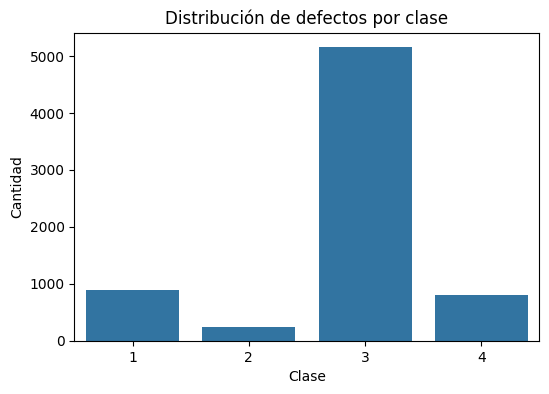

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["ClassId"])
plt.title("Distribución de defectos por clase")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.show()

El gráfico de barras muestra una clara desigualdad en la distribución de las
clases de defectos. Se observa que algunas clases presentan una cantidad
significativamente mayor de anotaciones en comparación con otras.

### **Porcentaje por clases de defectos**

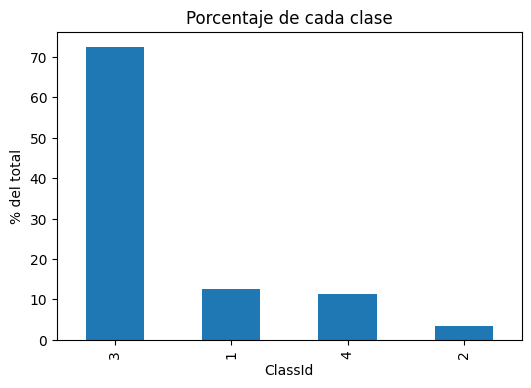

In [10]:
plt.figure(figsize=(6,4))
(df["ClassId"].value_counts(normalize=True) * 100).plot(kind="bar")
plt.title("Porcentaje de cada clase")
plt.ylabel("% del total")
plt.show()


El gráfico evidencia un **fuerte desbalance entre las clases de defectos**.
La clase 3 representa la mayor parte de las anotaciones (más del 70% del total),
mientras que las clases 1 y 4 presentan una frecuencia considerablemente menor,
y la clase 2 es claramente la menos representada.

Este desbalance implica que, durante el entrenamiento, el modelo podría tender a
favorecer la clase dominante, obteniendo buenos resultados globales pero un
desempeño deficiente en las clases minoritarias.


### **Imágenes con vs sin defectos**

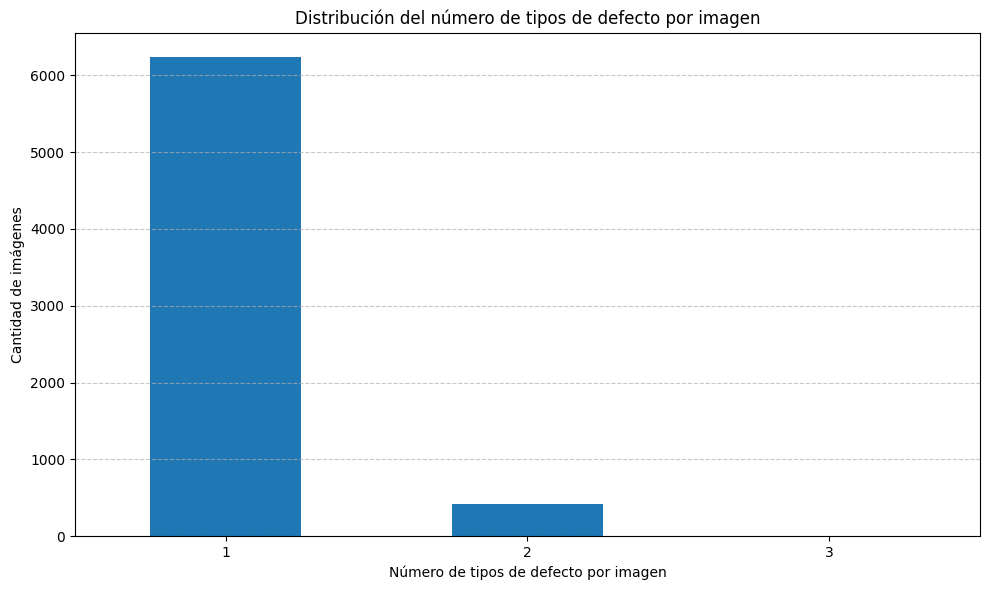

In [13]:
# Contar el número de tipos de defecto por imagen
# Se considera que una imagen tiene defecto si al menos una clase tiene EncodedPixels no nulo

defects_per_image = (
    df[df["EncodedPixels"].notnull()]
    .groupby("ImageId")["ClassId"]
    .nunique()
)

# Contar cuántas imágenes tienen 1, 2, 3, etc. tipos de defectos
distribution = defects_per_image.value_counts().sort_index()

# Visualización
plt.figure(figsize=(10, 6))
distribution.plot(kind="bar")
plt.xlabel("Número de tipos de defecto por imagen")
plt.ylabel("Cantidad de imágenes")
plt.title("Distribución del número de tipos de defecto por imagen")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


La distribución muestra que la mayoría de las imágenes contienen únicamente un
tipo de defecto. Un número considerablemente menor de imágenes presenta dos tipos
de defectos, mientras que los casos con tres tipos de defectos son poco frecuentes. Esto indica que, aunque el problema es multiclase, la complejidad a nivel de
imagen suele ser baja, lo cual puede facilitar el aprendizaje del modelo en la
mayoría de los casos.

### **Visualización del dataset (imagen + máscara)**

Se visualizan ejemplos del dataset combinando la imagen original
con su respectiva máscara de defectos. El objetivo es verificar la correcta
decodificación del formato RLE y comprender visualmente la naturaleza de los
defectos presentes en las imágenes.

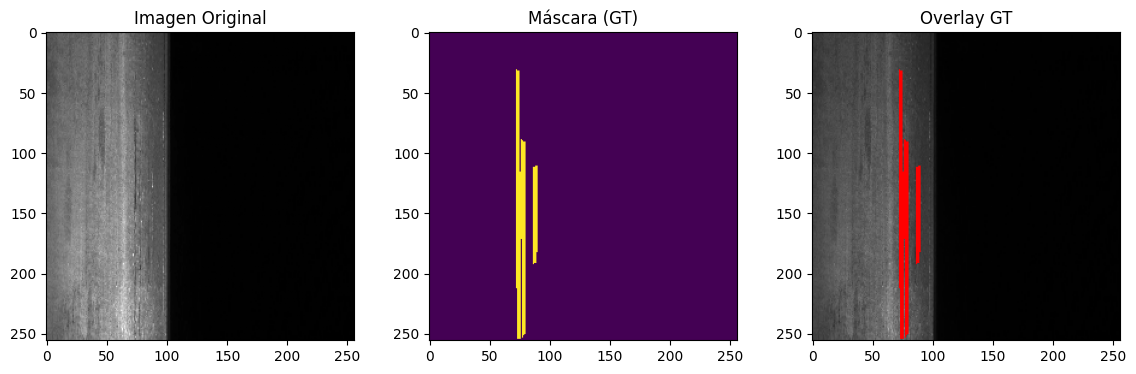

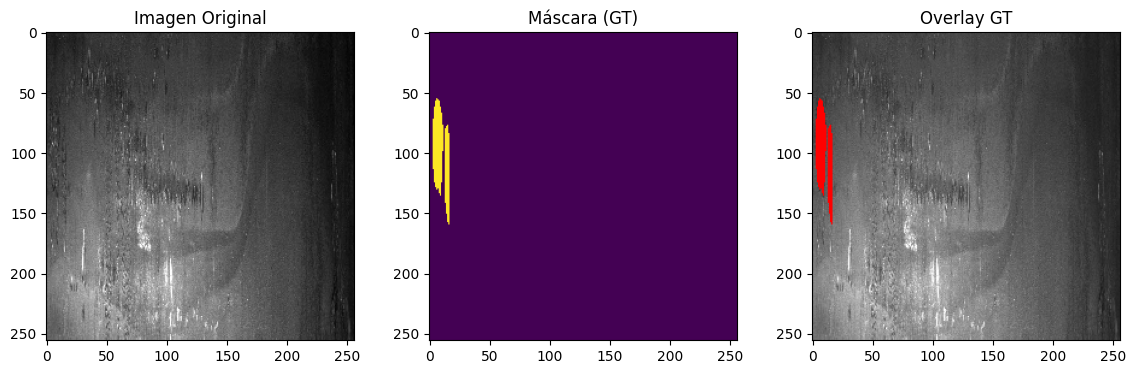

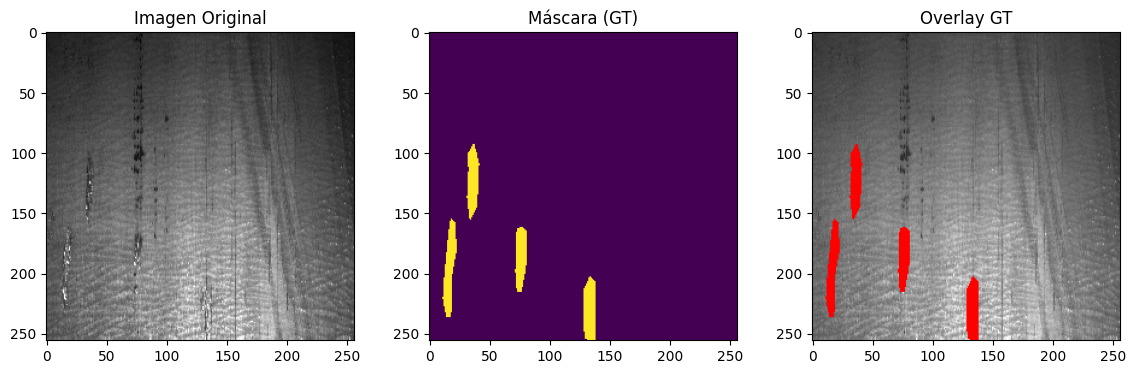

In [14]:
def show_sample(image_id, img_dir="../data/train_images"):
    df_img = df[df["ImageId"] == image_id]

    img = cv2.imread(f"{img_dir}/{image_id}", cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))

    mask = np.zeros((256, 256, 4), dtype=np.uint8)

    for _, row in df_img.iterrows():
        if isinstance(row["EncodedPixels"], str):
            class_id = int(row["ClassId"]) - 1
            decoded = rle_decode(row["EncodedPixels"], shape=(256,1600))
            decoded = cv2.resize(decoded, (256,256))
            mask[:,:,class_id] = decoded

    overlay = img.copy()
    overlay = cv2.cvtColor(overlay, cv2.COLOR_GRAY2BGR)
    overlay[mask.sum(axis=-1) > 0] = [255,0,0]  # rojo

    fig, ax = plt.subplots(1,3, figsize=(14,4))
    ax[0].imshow(img, cmap="gray")
    ax[0].set_title("Imagen Original")
    ax[1].imshow(mask.sum(axis=-1))
    ax[1].set_title("Máscara (GT)")
    ax[2].imshow(overlay)
    ax[2].set_title("Overlay GT")
    plt.show()

# Mostrar 3 imágenes aleatorias
samples = df["ImageId"].sample(3).values
for s in samples:
    show_sample(s)


Las visualizaciones muestran que los defectos suelen ocupar una pequeña región de
la imagen y presentan formas alargadas e irregulares. Esto confirma que el
problema corresponde a una tarea de segmentación semántica a nivel de píxel y que
existe un fuerte desbalance entre píxeles de fondo y píxeles defectuosos.


**Este análisis visual respalda la elección de arquitecturas especializadas en
segmentación, como U-Net, así como el uso de funciones de pérdida basadas en
superposición (Dice Loss), que resultan más adecuadas para defectos pequeños y
datasets desbalanceados.**

### **Comentarios y hallazgos del EDA**

El dataset está compuesto por 6666 imágenes de entrenamiento, cada una anotada para cuatro posibles clases de defectos, lo que confirma que se trata de un problema de segmentación semántica multiclase.

Existe un marcado desbalance entre las clases de defectos, donde una clase concentra la mayoría de las anotaciones, mientras que otras aparecen con mucha menor frecuencia, lo cual puede afectar el aprendizaje del modelo si no se emplean métricas y funciones de pérdida adecuadas.

A nivel de imagen, la mayoría de las imágenes no presentan defectos, evidenciando un fuerte desbalance entre imágenes defectuosas y no defectuosas, con predominancia de ejemplos negativos (acero sin defectos).

El análisis del número de defectos por imagen muestra que la mayoría de las imágenes con defectos contienen un único tipo de defecto, mientras que las imágenes con múltiples tipos de defectos son poco frecuentes, lo que limita la cantidad de ejemplos complejos disponibles para el entrenamiento.

Las anotaciones del dataset se encuentran codificadas mediante Run-Length Encoding (RLE), lo que requiere una conversión cuidadosa a máscaras binarias píxel a píxel antes de ser utilizadas por modelos de deep learning.

Las visualizaciones de imágenes junto con sus máscaras revelan que los defectos suelen ser pequeños, delgados y con formas irregulares, ocupando una proporción muy reducida del área total de la imagen, lo que incrementa la dificultad del problema y refuerza la necesidad de arquitecturas especializadas en segmentación.

En consecuencia, el preprocesamiento del dataset resulta crítico y debe contemplar:

* **Redimensionamiento** de las imágenes para balancear calidad y eficiencia computacional.
* **Normalización** de los valores de píxeles para facilitar la convergencia del entrenamiento.
* **Aumentos de datos ligeros**, cuidadosamente seleccionados, para mejorar la generalización del modelo sin distorsionar la estructura de los defectos.